In [48]:
import json
import matplotlib.pyplot as plt
import numpy as np

In [52]:
def importData(file):

    # open json file
    with open(file) as f:
        data = json.load(f)

    keys = [i for i in data.keys()]

    d_vectors = {}

    for key in keys:

        d_vectors[key] = {}
        vectors = data[key]["vectors"]

        measurement = data[key]["attributes"]["measurement"]
        repetition = data[key]["attributes"]["repetition"]
        configs = data[key]["config"]
        mergedConfigs={}
        for config in configs:
            mergedConfigs.update(config)
        timeLimit = mergedConfigs["sim-time-limit"]

        d_vectors[key]["measurement"] = measurement
        d_vectors[key]["repetition"] = int(repetition)
        
        assert timeLimit.endswith('s'), "Time limit format is incorrect"
        timeLimit = timeLimit[:-1]  # Remove the 's' at the end
        d_vectors[key]["timeLimit"] = int(timeLimit)

        for a in vectors:

            module = a["module"]
            name = a["name"]

            if not module in d_vectors[key]:
                d_vectors[key][module] = {}
            d_vectors[key][module][name] = {}

            d_vectors[key][module][name]["times"] = a["time"]
            d_vectors[key][module][name]["values"] = a["value"]

    return d_vectors


d_vectors = importData("../multicore_sched/simulations/test.json")

In [53]:
iterationvars=['numCpus','meanProcessDuration']

In [54]:
measurements=[]
numRepetitions=0

for key in d_vectors:

    measurement=d_vectors[key]['measurement']
    repetition=d_vectors[key]['repetition']

    if not measurement in measurements:
        measurements.append(measurement)
    
    numRepetitions=max(numRepetitions,repetition+1)

In [55]:
import colorsys
def getColors(numColors,numVariations):
    colors=[]
    for i in range(numColors):
        hue = i/numColors
        colors.append([])
        for j in range(numVariations):
            lightness = 0.4 + j / numVariations / 3  # Adjusting to reduce white
            saturation = 0.6 + j / numVariations / 3  # Adjusting to reduce white
            colors[i].append(colorsys.hls_to_rgb(hue, lightness, saturation))
    return colors

numColors = len(measurements)
numVariations = numRepetitions
colors = getColors(numColors, numVariations)

In [56]:
def showColors():
    # Plot colors
    fig, ax = plt.subplots(figsize=(numVariations, numColors))
    for i, row in enumerate(colors):
        for j, color in enumerate(row):
            ax.add_patch(plt.Rectangle((j, i), 1, 1, color=color))

    ax.set_xlim(0, numVariations)
    ax.set_ylim(0, numColors)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect('equal')
    plt.show()
# showColors()

In [57]:
def measurementLabel(measurement, endline=True):
    for j, iterationvar in enumerate(iterationvars):
        measurement = measurement.replace(f"${j}", f"{iterationvar}")
    if endline:
        measurement = measurement.replace(', ', '\n')
    return measurement

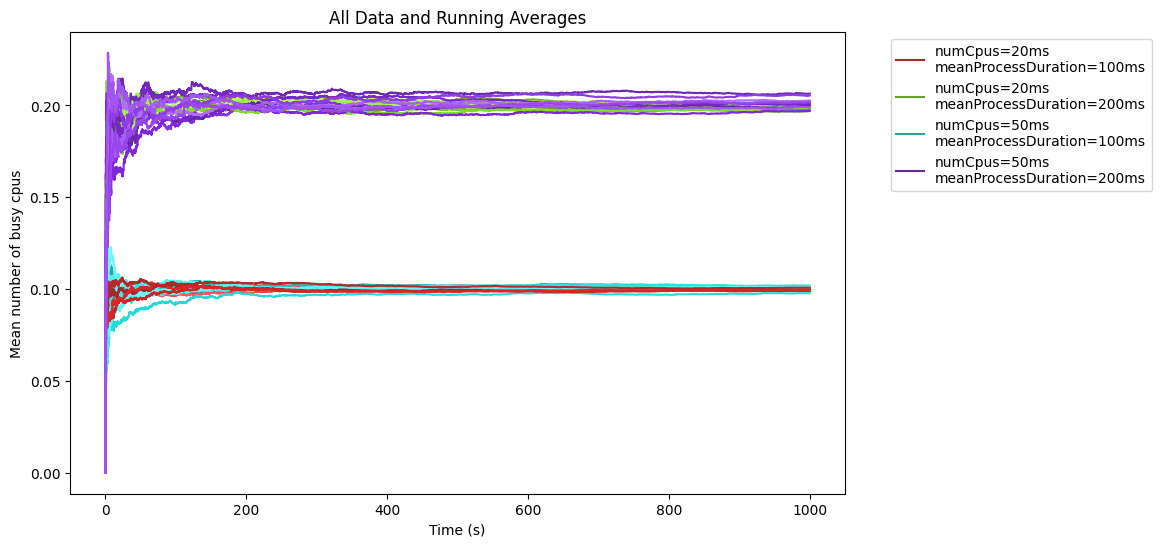

In [61]:
for key in d_vectors:

    measurement=d_vectors[key]['measurement']
    repetition=d_vectors[key]['repetition']
    timeLimit=d_vectors[key]['timeLimit']

    color=colors[measurements.index(measurement)][repetition]

    times = d_vectors[key]["Computer.scheduler"]["turnaroundTime:vector"]["times"]
    values = d_vectors[key]["Computer.scheduler"]["turnaroundTime:vector"]["values"]

    # Calculate running average
    cumulative_sum = 0
    running_average = []
    times=times+[timeLimit]
    running_average.append(0)
    for i, v in enumerate(values):
        cumulative_sum += v * (times[i+1] - times[i])
        average = cumulative_sum / times[i+1]
        running_average.append(average)

        # variance=0
        # for j in range(i):
        #     variance+=(time[j+1] - time[j])*(value[j]-average)**2
        # variance=variance/time[i+1]



    plt.plot(times, running_average,color=color)

# Plt labels
for i, measurement in enumerate(measurements):
    plt.plot([], [], color=colors[i][0], label=f'{measurementLabel(measurement)}')

plt.xlabel('Time (s)')
plt.ylabel('Mean number of busy cpus')
plt.title('All Data and Running Averages')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.gcf().set_size_inches(10, 6)
plt.show()

In [62]:

def weighted_avg_and_std(values, weights):
    average = np.average(values, weights=weights)
    # Biased variance
    variance = np.average((values-average)**2, weights=weights)
    return (average, np.sqrt(variance))

In [70]:
import pandas as pd

plot_data = []

for key in d_vectors:
    measurement = d_vectors[key]["measurement"]
    repetition = d_vectors[key]["repetition"]
    timeLimit = d_vectors[key]["timeLimit"]

    print(
        f"Measurement: {measurementLabel(measurement, endline=False)}, Repetition: {repetition}\n"
    )

    times = d_vectors[key]["Computer.scheduler"]["turnaroundTime:vector"]["times"]
    values = d_vectors[key]["Computer.scheduler"]["turnaroundTime:vector"]["values"]

    # Initialize data structure for table
    table_data = []

    # Calculate running average
    cumulative_sum = 0
    running_average = []
    times = times + [timeLimit]
    running_average.append(0)

    stop_times = [0.001 * (2**i) for i in range(timeLimit)]
    stop_times = [a for a in stop_times if a < timeLimit]
    
    for time in stop_times:
        times_lower = [t for t in times if t <= time]
        weights = [
            times_lower[i + 1] - times_lower[i] for i in range(len(times_lower) - 1)
        ]
        values_lower = values[: len(times_lower) - 1]

        if sum(weights) == 0:
            continue

        average, std = weighted_avg_and_std(values_lower, weights)
        table_data.append([time, average, std])

    # Create a DataFrame for better table display
    df = pd.DataFrame(table_data, columns=["Time", "Average", "Standard Deviation"])
    print(df.to_string(index=False))
    print("\n")

        # Plot standard deviation against time
    plot_data.append({
        'label': f"Repetition {repetition} - {measurementLabel(measurement)}",
        'times': df['Time'],
        'std': df['Standard Deviation']
    })

Measurement: numCpus=20ms, meanProcessDuration=100ms, Repetition: 4

   Time  Average  Standard Deviation
  0.128 0.027121            0.000000
  0.256 0.109076            0.049954
  0.512 0.121942            0.075884
  1.024 0.097730            0.091886
  2.048 0.101994            0.090853
  4.096 0.096311            0.097332
  8.192 0.098881            0.099819
 16.384 0.100726            0.100423
 32.768 0.098428            0.097933
 65.536 0.098699            0.099939
131.072 0.100444            0.100257
262.144 0.100528            0.099664
524.288 0.100451            0.099572


Measurement: numCpus=20ms, meanProcessDuration=100ms, Repetition: 5

   Time  Average  Standard Deviation
  0.128 0.020366            0.008487
  0.256 0.036385            0.019979
  0.512 0.057605            0.049926
  1.024 0.069894            0.068757
  2.048 0.081206            0.072288
  4.096 0.097460            0.094751
  8.192 0.099307            0.090072
 16.384 0.097348            0.091611
 32.768 0

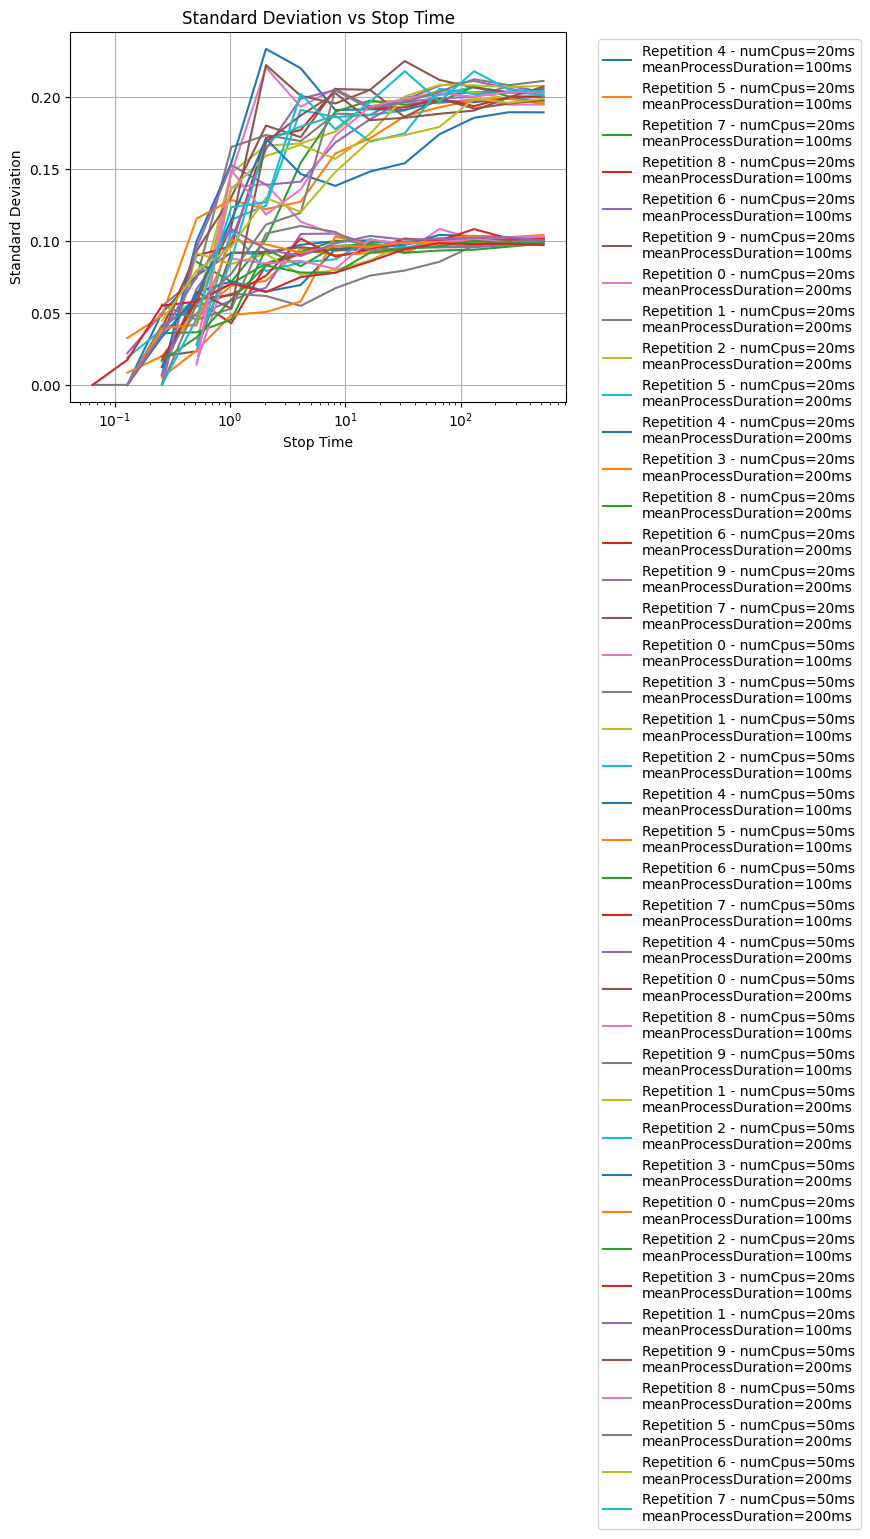

In [73]:
import matplotlib.pyplot as plt

# Plot standard deviation against time for each entry in plot_data
for data in plot_data:
    plt.plot(data['times'], data['std'], label=data['label'])

# Customize the plot
plt.xlabel('Stop Time')
plt.ylabel('Standard Deviation')
plt.xscale('log')
plt.title('Standard Deviation vs Stop Time')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()


In [ ]:
#plot the 